In [2]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

# Step 2: Create a Data Generator
class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, img_size=(128, 128), n_classes=None, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = [self.load_image(file_path) for file_path in batch_paths]
        return np.array(images), to_categorical(batch_labels, num_classes=self.n_classes)
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.file_paths))
            np.random.shuffle(indices)
            self.file_paths = [self.file_paths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
    
    def load_image(self, file_path):
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, self.img_size)
            img = img.astype('float32') / 255.0
        return img


In [ ]:

# Step 3: Load file paths and labels
def load_file_paths_and_labels(folder_path):
    file_paths = []
    labels = []
    class_names = os.listdir(folder_path)
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                file_paths.append(img_path)
                labels.append(label)
    return file_paths, labels, class_names

data_folder = r'C:\saanvi_code\CropDoctor\dataset'  # Replace with actual data path
file_paths, labels, class_names = load_file_paths_and_labels(data_folder)

# Step 4: Split data into training and testing sets
file_paths_train, file_paths_test, labels_train, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)


In [7]:

# Step 5: Create Data Generators for training and testing
batch_size = 32
train_generator = DataGenerator(file_paths_train, labels_train, batch_size=batch_size, 
                                img_size=(128, 128), n_classes=len(class_names))
test_generator = DataGenerator(file_paths_test, labels_test, batch_size=batch_size, 
                               img_size=(128, 128), n_classes=len(class_names))


In [ ]:

# Step 6: Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


In [9]:

# Step 7: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
# Step 8: Add callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

checkpoint_path = 'best_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)


In [28]:

# Step 8: Train the model using data generators
history = model.fit(train_generator, epochs=20, validation_data=test_generator)


Epoch 1/20
4991/4991 [==============================] - 279s 56ms/step - loss: 0.8487 - accuracy: 0.7554 - val_loss: 0.3092 - val_accuracy: 0.9054
Epoch 2/20
4991/4991 [==============================] - 272s 55ms/step - loss: 0.3664 - accuracy: 0.8847 - val_loss: 0.2020 - val_accuracy: 0.9384
Epoch 3/20
4991/4991 [==============================] - 269s 54ms/step - loss: 0.2646 - accuracy: 0.9160 - val_loss: 0.1784 - val_accuracy: 0.9437
Epoch 4/20
4991/4991 [==============================] - 269s 54ms/step - loss: 0.2166 - accuracy: 0.9307 - val_loss: 0.1330 - val_accuracy: 0.9583
Epoch 5/20
4991/4991 [==============================] - 271s 54ms/step - loss: 0.1835 - accuracy: 0.9412 - val_loss: 0.1352 - val_accuracy: 0.9586
Epoch 6/20
4991/4991 [==============================] - 269s 54ms/step - loss: 0.1642 - accuracy: 0.9483 - val_loss: 0.1523 - val_accuracy: 0.9546
Epoch 7/20
4991/4991 [==============================] - 268s 54ms/step - loss: 0.1422 - accuracy: 0.9550 - val_loss: 0

In [ ]:

# Step 9: Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')


1247/1247 [==============================] - 40s 32ms/step - loss: 0.1718 - accuracy: 0.9684
Test accuracy: 0.97


In [30]:

# Step 10: Save the model
model.save('plant_disease_model.h5')


In [10]:
import json

# Assuming `class_names` contains your list of class names
class_dict = {str(i): class_name for i, class_name in enumerate(class_names)}

# Specify the path for the JSON file
json_path = 'classes.json'

# Save the dictionary to classes.json
with open(json_path, 'w') as f:
    json.dump(class_dict, f, indent=4)

print(f"Class names saved to {json_path}")


Class names saved to classes.json


In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt

# Step 1: Load the model and class names
model_path = 'plant_disease_model.h5'  # Model file path
model = load_model(model_path)

json_path = 'classes.json'  # Class names file path
with open(json_path, 'r') as f:
    class_names = json.load(f)


In [2]:

# Step 2: Preprocess the image
def preprocess_image(img_path, img_size=(128, 128)):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [3]:

# Step 3: Predict the class for a new image
def predict_image(img_path):
    img = preprocess_image(img_path)
    if img is not None:
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[str(predicted_class_index)]
        confidence = prediction[0][predicted_class_index]
        return predicted_class_name, confidence
    else:
        return None, None


In [4]:

# Step 4: Display the image with prediction result
def show_image_with_prediction(img_path):
    predicted_class, confidence = predict_image(img_path)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

    if predicted_class:
        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence:.2f})", fontsize=15, color='green')
        plt.show()
    else:
        print("Error: Could not process the image.")


1/1 [==============================] - 0s 47ms/step


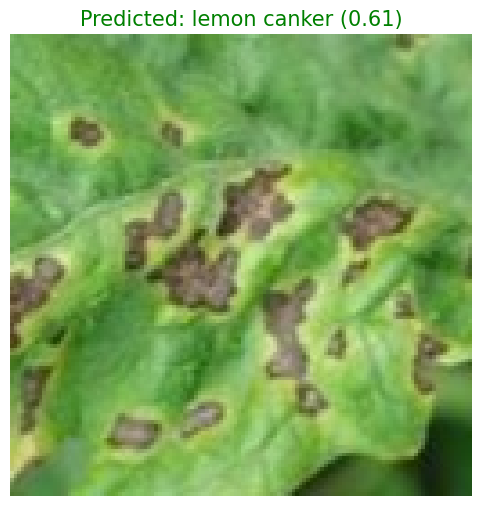

In [8]:

# Test with a sample image
sample_image_path = r''  # Replace with actual image path
show_image_with_prediction(sample_image_path)
